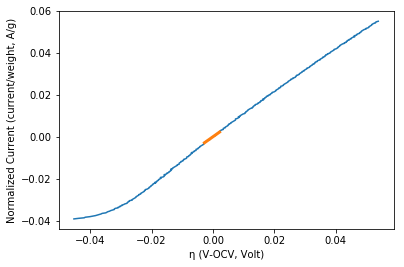

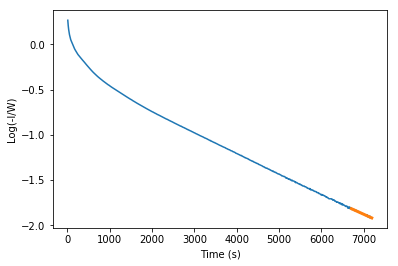

Channel- 019
I0=  26.6046279662 (mA/g)
D=  1.98145012326 (10^(-10) cm^2/s)


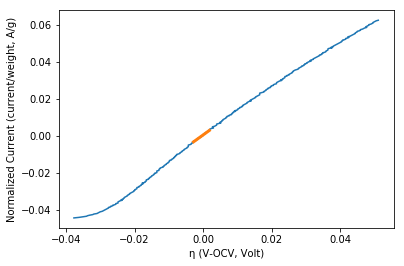

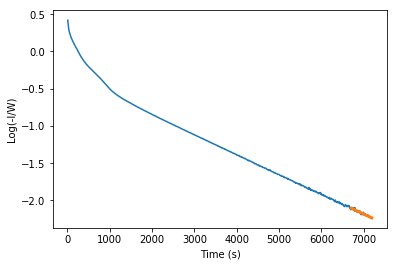

Channel- 020
I0=  34.1964709719 (mA/g)
D=  2.53935927723 (10^(-10) cm^2/s)


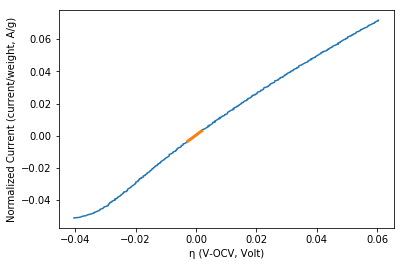

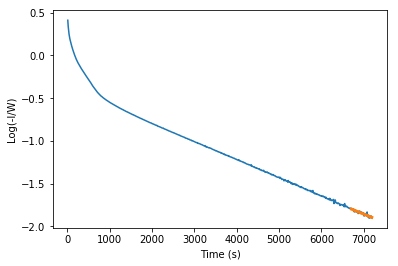

Channel- 021
I0=  35.6505306988 (mA/g)
D=  1.88743558945 (10^(-10) cm^2/s)


In [2]:
## Written by Hong-Kang Tian at BASF (Rochester Hills, MI), 2018/8
## Use for calculating diffusion coefficient (D) and exchange current (I0), and the plots
## Need to export all the tabs in raw data to individual csv files (Channel and global information files)
## Put all the csv files under the same folder (specify the path in the input secion)
## The output file will be csv format 

import csv
import numpy
import os
import matplotlib.pyplot as plt
import math


#### Input section

#This path will be different in MacOX and Windows
Folder_Path = '/Users/HONG-KANG/Documents/BASF/Python Code/Jean/'   
Output_File_Name = 'output-Jean.csv'
Global_Information_File_Name = 'Global_Info-Table 1.csv'

I0_range = 10   #  The number of data points above and below the OCV
D_range = 50    #  The number of data points from the end of the curve of log(-I/w) vs. step_time

R = 8.3144598    # Ideal gas constant
F = 96487        # Faraday constant
T = 298          # Temperature

#### Input section ends



# Record the file name separately in the folder
File_name_list = os.listdir(Folder_Path)
Global_file_index = File_name_list.index(Global_Information_File_Name)  # Find the position of Global Information file
del File_name_list[Global_file_index]                                   # Leave the channel names in the list only

# Open the global information file
with open(Folder_Path+Global_Information_File_Name,'r', newline='') as Global_original_file:
    Global_csv=csv.reader(Global_original_file,delimiter=',')        # Read Global_raw_data as csv format
    Weight_data=[]
    for rows in Global_csv:
        Weight_data.append(rows[10])                                 # Only record the weight of each channel
Global_original_file.close
del Weight_data[0:4]                                                 # Delete the unnecessary information

with open(Output_File_Name, 'w', newline='') as csvfile:             # Rewrite the output file to strat from blank
    writer = csv.writer(csvfile)
csvfile.close

# Open the Channel file one by one to calculate
File_name_list.sort()
for i in File_name_list:
    File_order = File_name_list.index(i)                        # let the file order starts from 1
    
    # Open the output file and write the title row
    with open(Output_File_Name, 'a', newline=None) as csvfile:  
            writer = csv.writer(csvfile)
            writer.writerow('')
            writer.writerow(['','D (10^(-10)cm^2/s)', 'I0 (mA/g)'])
    csvfile.close
       
    # Get the needed information from the channel
    Step_Time = []      
    Current =[] 
    Step_Index = []
    Voltage = []
    with open(Folder_Path+i,'r', newline='',encoding='utf-8') as Raw_Data:       # Open individual channel file
        All_Data_Record=csv.reader(Raw_Data,delimiter=',')  
        for rows in All_Data_Record:                          # Only record the neccessary data
            Step_Time.append(rows[3]) 
            Current.append(rows[6])
            Step_Index.append(rows[4])
            Voltage.append(rows[7])
    Raw_Data.close
    
    #### Calculate I0
    
    # Convert the data list from string to numbers
    Current_float=[]
    Voltage_float=[]
    Step_Time_float=[]
    for n in Current[1:]:
        Current_float.append(float(n))
    for n in Voltage[1:]:
        Voltage_float.append(float(n))    
    for n in Step_Time[1:]:
        Step_Time_float.append(float(n))  
    
    # Normalize current by weight    
    Normalized_current=[] 
    for n in Current_float:
        Normalized_current.append(float(n)/float(Weight_data[File_order]))
        
    # Find the step 4 and 6 position 
    Step_4_start = Step_Index.index('4')-1
    Step_4_end = Step_Index.index('5')-2
    Step_6_start = Step_Index.index('6')-1
    Step_6_end = len(Step_Index)-2
    
    
    # Find the OCV position
    OCV_index=[]
    for j in Current_float[Step_4_start:Step_4_end]:
        if j>0:
            OCV_index = Current_float.index(j)
            break
    
    # Record the OCV value 
    OCV = []
    OCV = Voltage_float[OCV_index]
    
    # Calculate the overpotential for each step_time
    Over_potential=[]
    for k in Voltage_float:
        Over_potential.append(k-OCV)
    
    # Fit the data points around OCV to get the straight line 
    fit_I0 = numpy.polyfit(Over_potential[OCV_index-I0_range:OCV_index+I0_range],\
                    Normalized_current[OCV_index-I0_range:OCV_index+I0_range],1)   
    fit_fn_I0 = numpy.poly1d(fit_I0) 
    
    # Calculate the exchange current (I0)
    I0 = R*T/F*fit_I0[0]*1000
    # Plot the normalized current vs. overpotential
    plt.plot(Over_potential[Step_4_start:Step_4_end],Normalized_current[Step_4_start:Step_4_end])
    plt.plot(Over_potential[OCV_index-I0_range:OCV_index+I0_range],\
             fit_fn_I0(Over_potential[OCV_index-I0_range:OCV_index+I0_range]),lw=3)
    plt.xlabel('\u03B7 (V-OCV, Volt)')
    plt.ylabel('Normalized Current (current/weight, A/g)')
    plt.show()
    
    #### Finish the calculation of I0
    
    #### Calculation of diffusion coefficient
    
    # Calculate the logarithm value of normalized current
    Log_normalized_current_step_6=[]
    for n in Normalized_current[Step_6_start:]:
        if n>0:
            n=-n
        Log_normalized_current_step_6.append(math.log10(-n))
    
    # Fit the data points from the end of the curve
    Step_Time_float_step_6 = Step_Time_float[Step_6_start:]
    Number_data_step_6 = len(Log_normalized_current_step_6)
    fit_D = numpy.polyfit(Step_Time_float_step_6[Number_data_step_6-D_range:Number_data_step_6-1],\
                          Log_normalized_current_step_6[Number_data_step_6-D_range:Number_data_step_6-1],1)   
    fit_fn_D = numpy.poly1d(fit_D)
    
    
    # Calculate the D (10^-10 cm2/s)
    D = -(0.002**2*2.303/3.14/3.14)*fit_D[0]*10**10
    
    plt.plot(Step_Time_float[Step_6_start:],Log_normalized_current_step_6)
    plt.plot(Step_Time_float_step_6[Number_data_step_6-D_range:Number_data_step_6-1],\
             fit_fn_D((Step_Time_float_step_6[Number_data_step_6-D_range:Number_data_step_6-1])),lw=3)
    plt.xlabel('Time (s)')
    plt.ylabel('Log(-I/W)')
    plt.show()
    
    with open(Output_File_Name, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Channel '+ i[10:13], D,I0])
    csvfile.close
    
    print('Channel-', i[10:13])
    print('I0= ', I0, '(mA/g)')
    print('D= ', D,'(10^(-10) cm^2/s)')
    
    
    
    

In [20]:
File_name_list

['.DS_Store',
 'Channel_1-019-Table 1.numbers',
 'Channel_1-020-Table 1.numbers',
 'Channel_1-021-Table 1.numbers']

In [18]:
Voltage

['Current (A/g)',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '